In [1]:
import numpy.random as npr

import jax
import jax.numpy as jnp 
import jax.random as jrnd
from jaxutils import Dataset

import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# Imports from our code base
from elliptical_slice_sampler_jax import elliptical_slice_jax
from active_search import get_next_y, get_next_candidate_baseline
from plotting import plot_candidate, plot_eig
from gp_model import update_model
from search_no_gpjax import generate_true_function, sample_from_posterior

# Generate data

In [3]:
n_grid = 10

nx, ny = (n_grid, n_grid)
x = jnp.linspace(0, 1, nx)
y = jnp.linspace(0, 1, ny)
xv, yv = jnp.meshgrid(x, y)
train_x = jnp.array([xv.flatten(),yv.flatten()]).T
# filter out things that are greater than 1
design_space = train_x[train_x.sum(1) <= 1]
pts = []
for x in design_space:
    pts.append((x[0], x[1], 1-x.sum()))
    
knot_N = len(design_space)

In [4]:
npr.seed(10)

true_y, true_envelope = generate_true_function(design_space, knot_N)

tights = (true_y - true_envelope) <= 1e-3
tight_designs = design_space[tights.ravel(),:]
tight_pts = []
for x in tight_designs:
    tight_pts.append((x[0], x[1], 1-x.sum()))
    
    
# Set random seed
#npr.seed(2)
rng_key = jrnd.PRNGKey(1)

num_iters = 1
design_inds = jnp.array(range(knot_N))

# observations
train_x = jnp.array([design_space[0], design_space[30], design_space[-1]])
train_y = jnp.array([true_y[0], true_y[30], true_y[-1]])
data = (train_x, train_y)

In [5]:
data

(Array([[0.        , 0.        ],
        [0.33333333, 0.33333333],
        [0.        , 1.        ]], dtype=float64),
 Array([ 1.33158651, -0.47721525,  0.32538117], dtype=float64))

# Baseline: no convex hull information

CPU times: user 2.11 s, sys: 33.8 ms, total: 2.15 s
Wall time: 2.17 s
CPU times: user 1.7 s, sys: 20.7 ms, total: 1.72 s
Wall time: 1.73 s
CPU times: user 1.69 s, sys: 23.5 ms, total: 1.72 s
Wall time: 1.73 s
CPU times: user 1.56 s, sys: 15.9 ms, total: 1.57 s
Wall time: 1.58 s
CPU times: user 1.57 s, sys: 21.3 ms, total: 1.59 s
Wall time: 1.6 s
CPU times: user 1.45 s, sys: 12.6 ms, total: 1.46 s
Wall time: 1.46 s


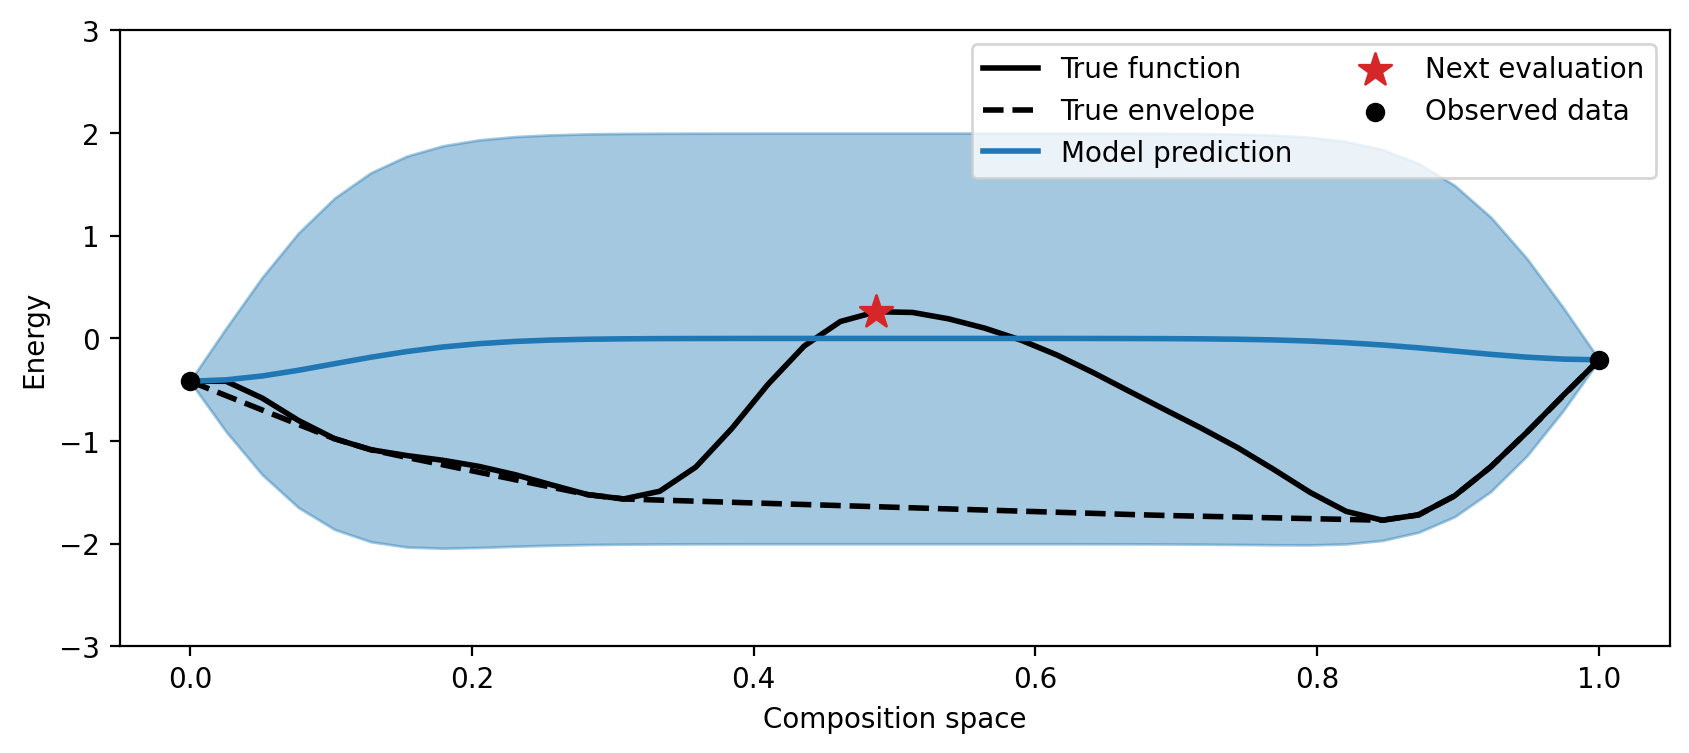

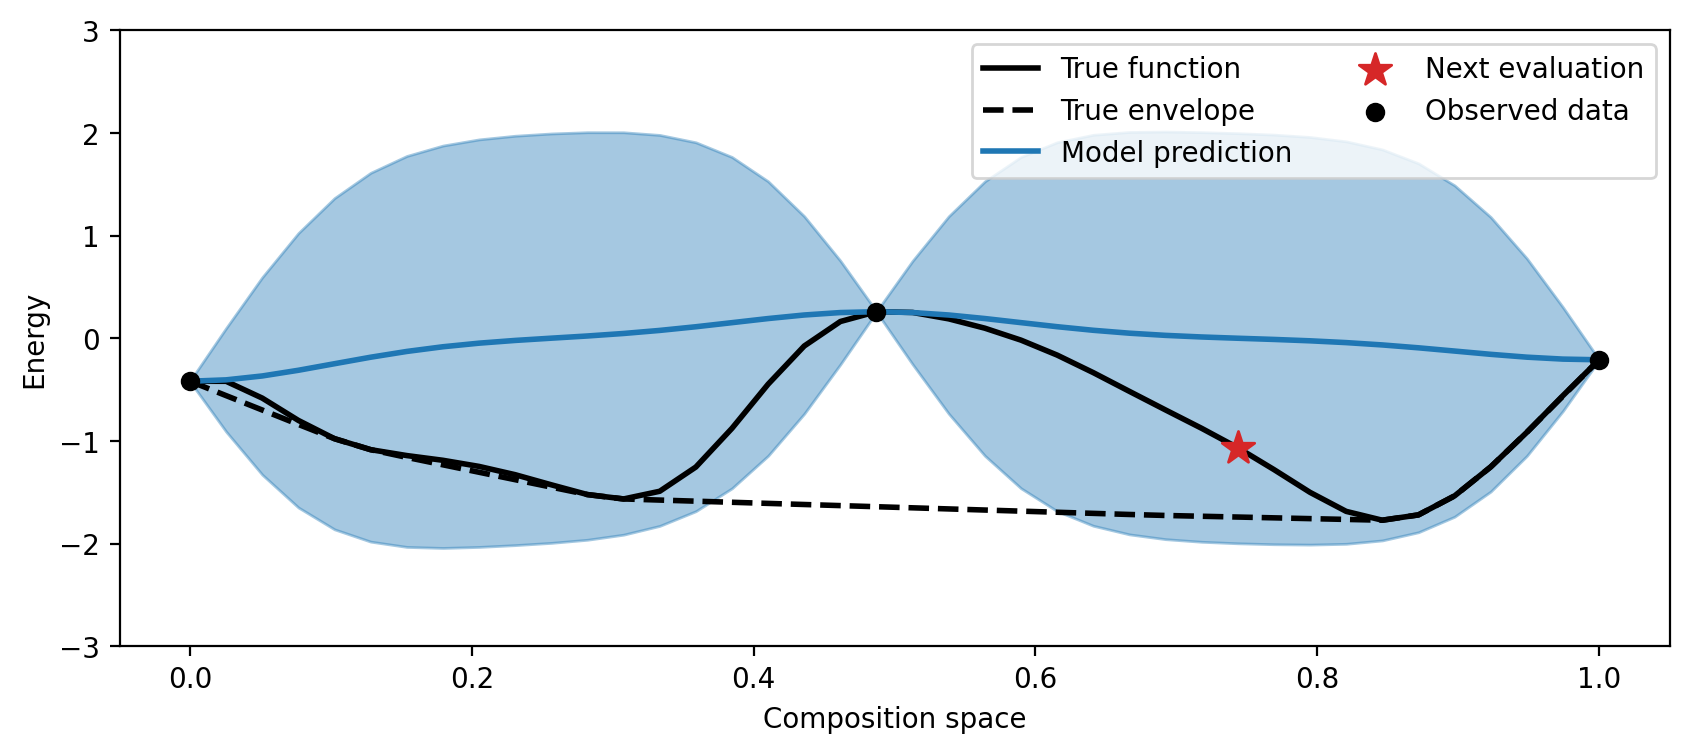

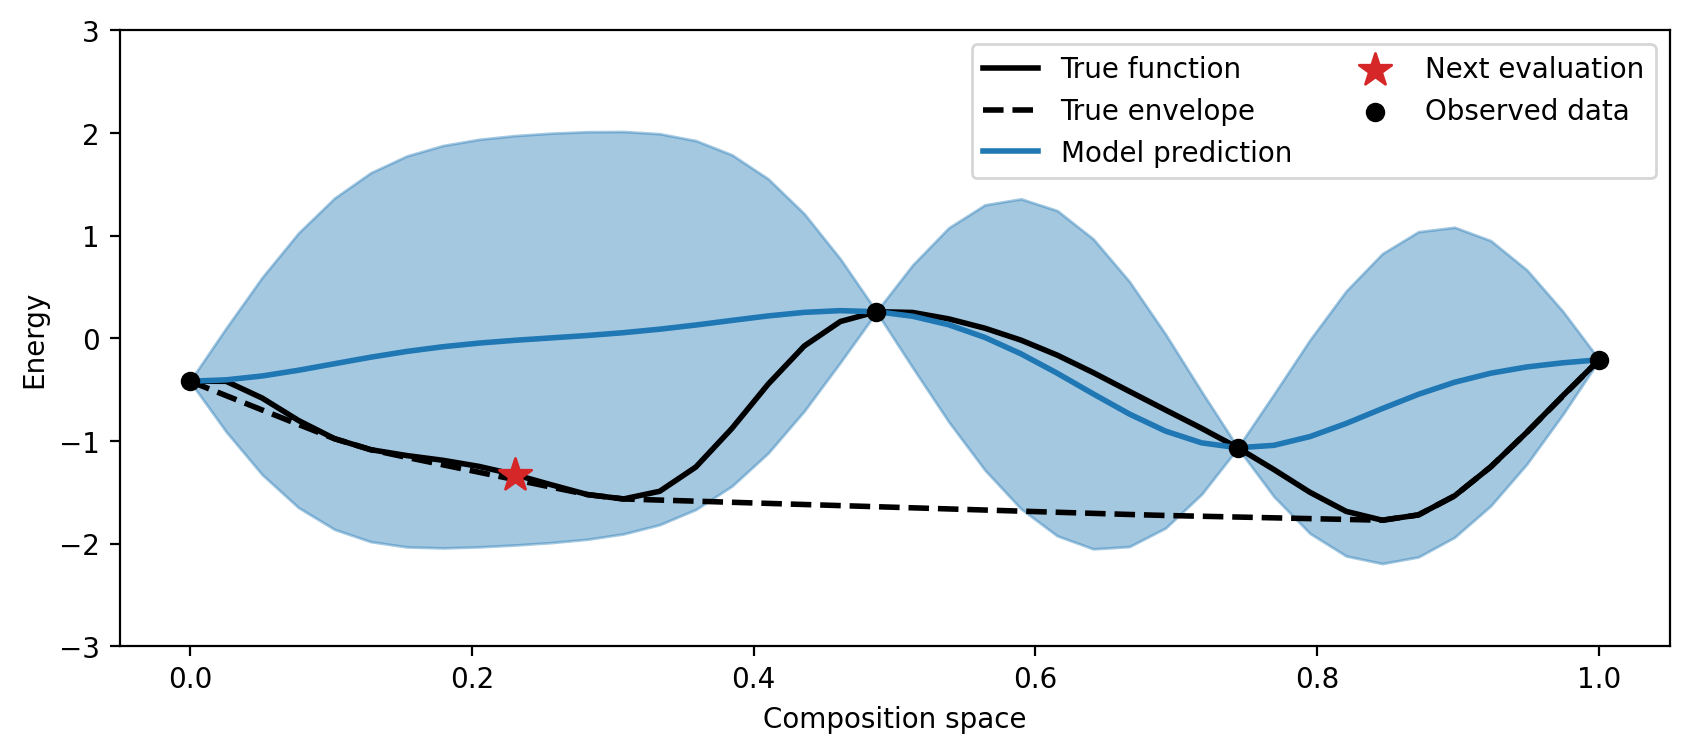

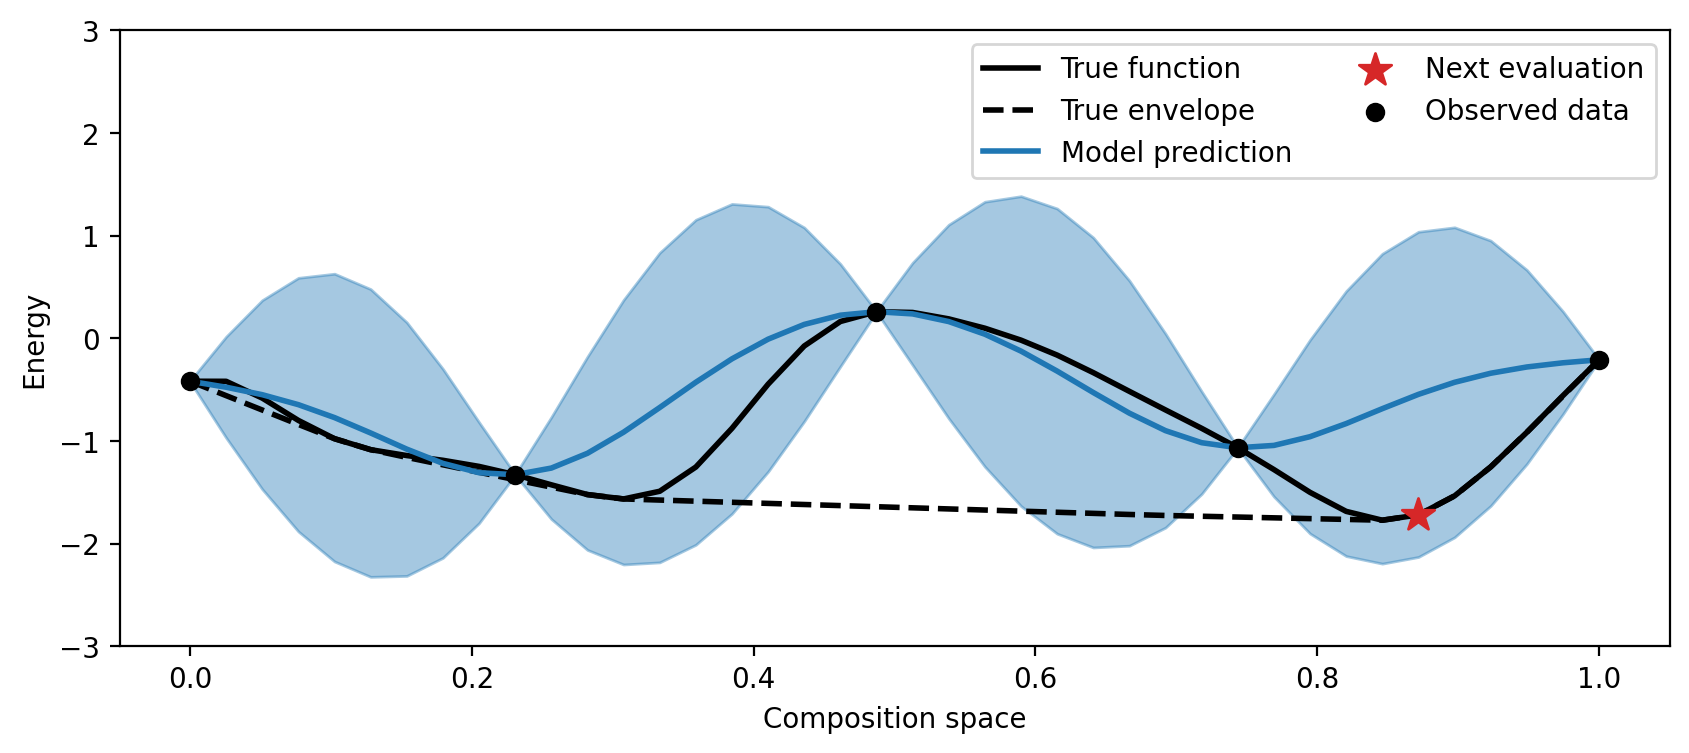

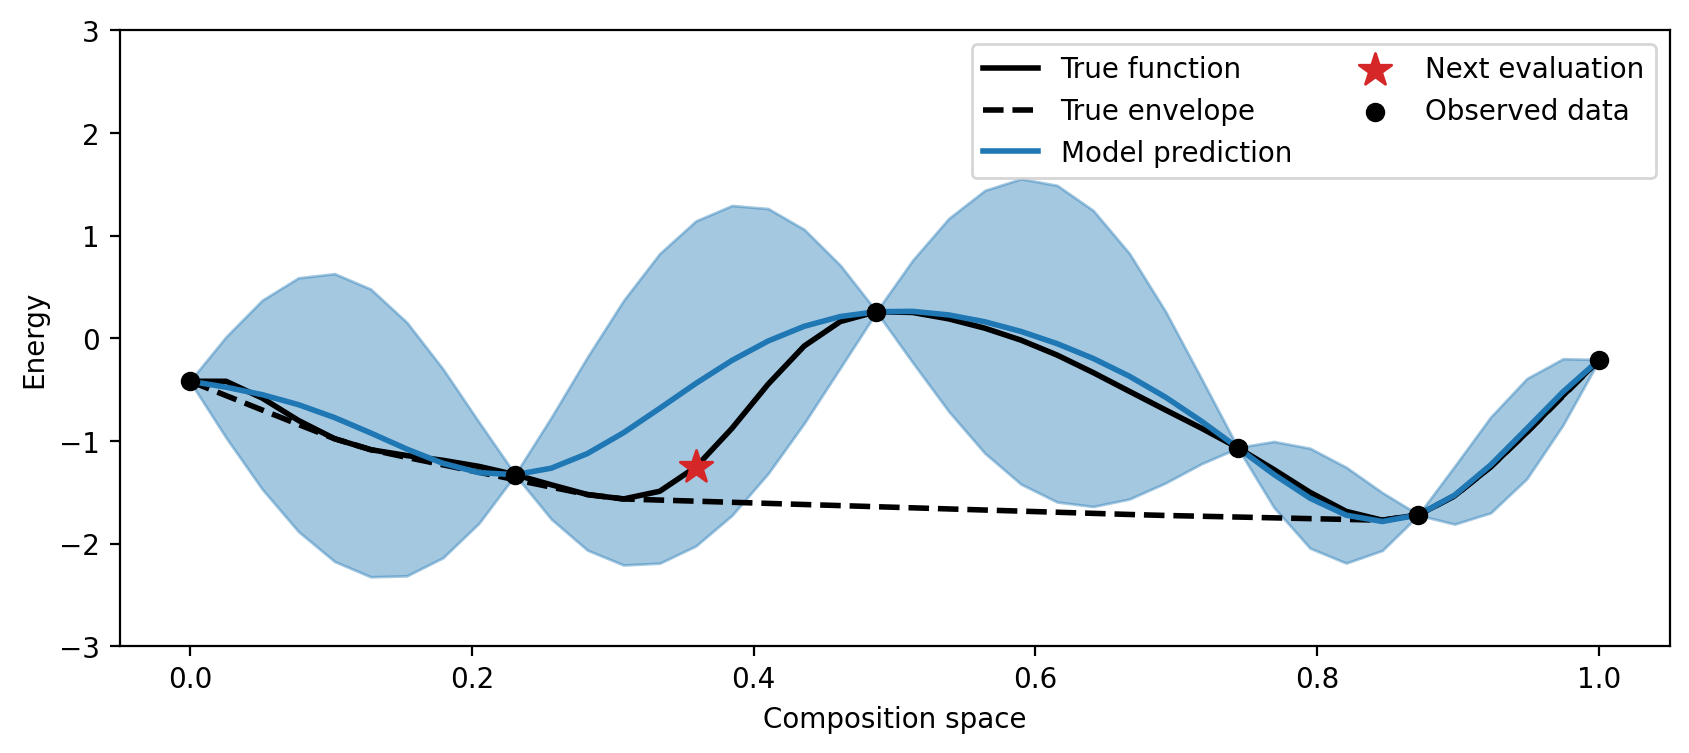

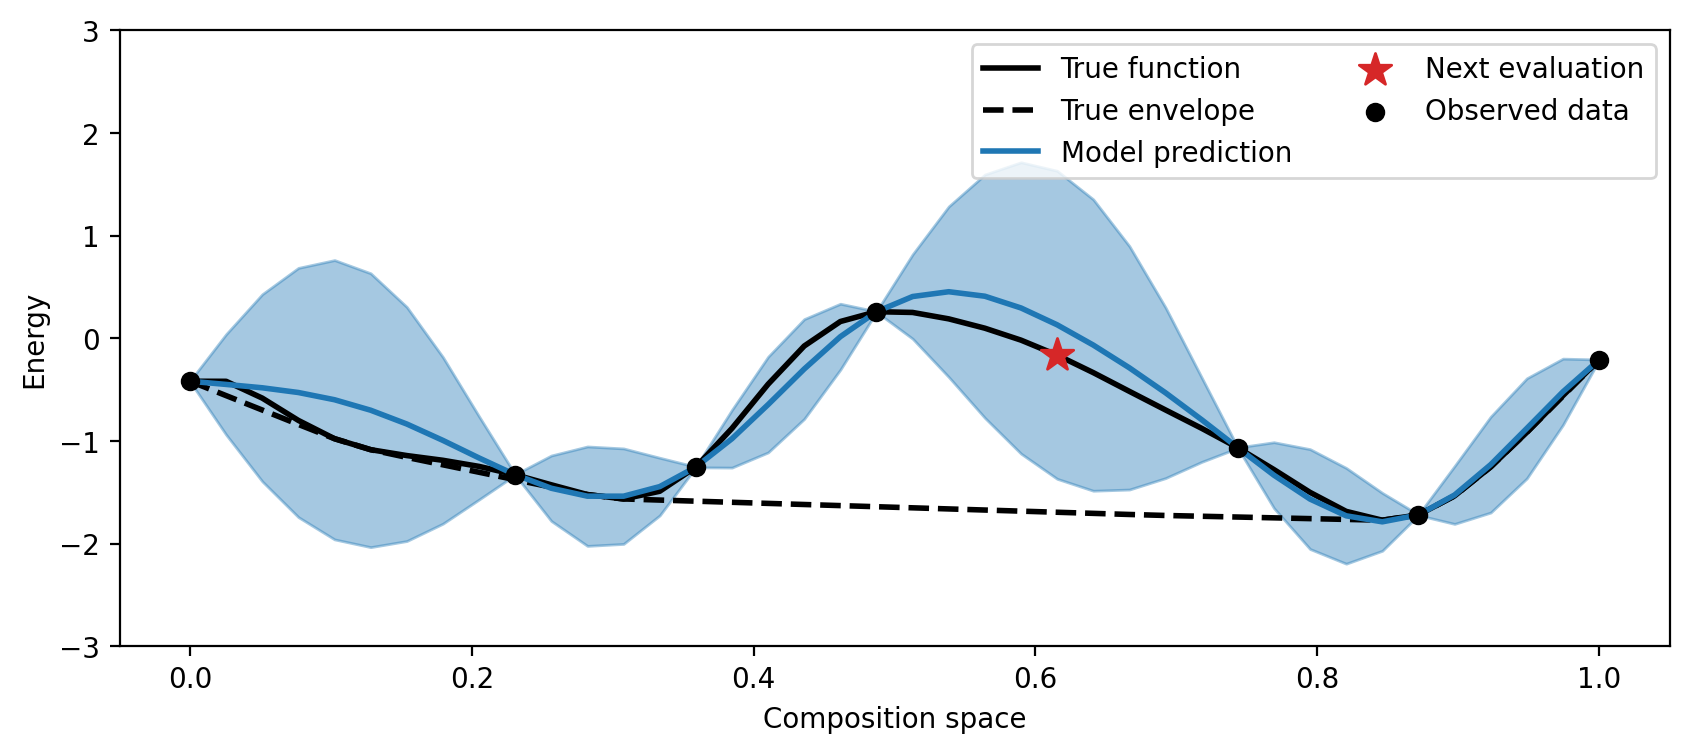

In [3]:
seed = 2; npr.seed(seed); rng_key = jrnd.PRNGKey(seed)
num_iters = 6 # number of iterations to run
knot_N = 40 # number of points to discretize space into

# grid to discretize design space into
knot_x = jnp.linspace(0, 1, knot_N)
design_space = knot_x[:, jnp.newaxis]

true_y, true_envelope = generate_true_function(design_space, knot_N)

# Suppose we start out by observing the two end points
train_x = jnp.array([design_space[0], design_space[-1]]); train_y = jnp.array([true_y[0], true_y[-1]])
dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])
designs = design_space[1:-1]

# Update the model given the data above
pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)

for i in range(num_iters):

    %time next_x, entropy_change = get_next_candidate_baseline(posterior, params, dataset, designs, design_space)
    #print(entropy_change)
    plot_candidate(knot_x, true_y, true_envelope, pred_mean, pred_cov, [], dataset, next_x, entropy_change, plot_eig=False, plot_hulls=False)
    
    # add observations to data and update model
    dataset = dataset + Dataset(X=jnp.atleast_2d(next_x), y=jnp.atleast_2d(get_next_y(true_y, design_space, next_x)))
    designs = jnp.delete(designs, (designs == next_x).argmax())[:, jnp.newaxis]
    pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)